In [10]:
# Imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from PIL import Image
import matplotlib.pyplot as plt

import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

In [11]:
# Load SAM
model_type = 'default'
model_ckpt = 'sam_vit_h_4b8939.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=model_ckpt).to(device=device)
predictor = SamPredictor(sam)

(1080, 1920, 3) (1080, 1920) [0 1 2 3]


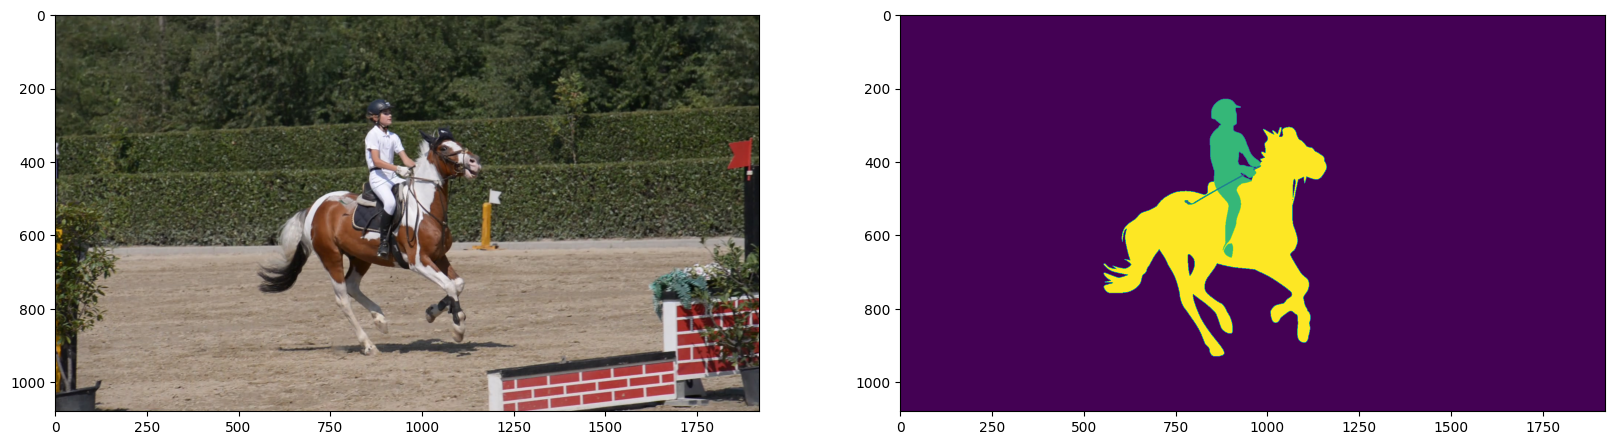

In [12]:
# Load the initial frame and masks
init_idx = 0
vid_dir = 'demo'
init_masks = np.array(Image.open(f'{vid_dir}/{init_idx:05d}.png'))
init_img = np.array(Image.open(f'{vid_dir}/{init_idx:05d}.jpg').convert('RGB'))
print(init_img.shape, init_masks.shape, np.unique(init_masks))
# 0: background, 1: stick, 2: human, 3: horse

# Visualize the initial frame and masks
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(init_img)
plt.subplot(1, 2, 2)
plt.imshow(init_masks)
plt.show()

In [13]:
# Working on the initial frame
predictor.set_image(init_img)
init_feat = predictor.features
print(init_feat.shape) # torch.Size([1, 256, 64, 64])
 
long_side = max(init_masks.shape) # 1920, which is a multiple of 64
scale_factor = long_side // init_feat.shape[-1] # 1920/64 = 30
feat_size = init_img.shape[0]//scale_factor, init_img.shape[1]//scale_factor # (1080/30, 1920/30) = (36, 64)

# Ignore padding
init_feat = init_feat[:, :, :feat_size[0], :feat_size[1]]
print(init_feat.shape) # torch.Size([1, 256, 36, 64])

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 36, 64])


6 11


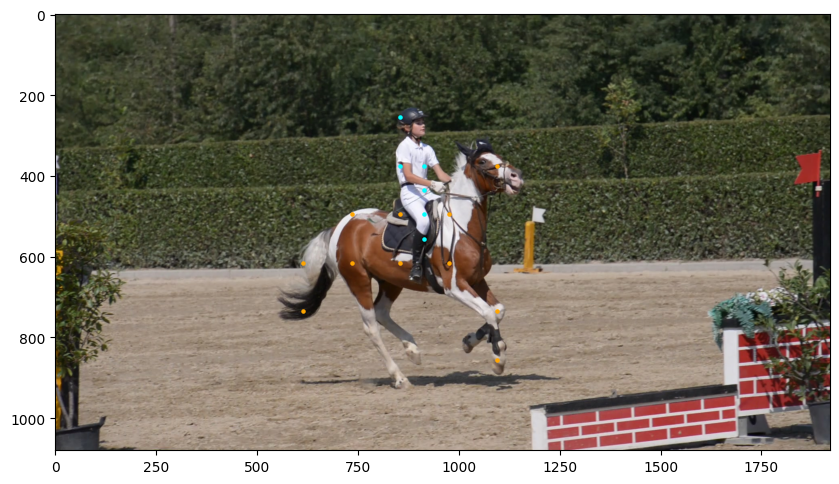

In [14]:
# Sample points from the initial masks of human and horse
# TODO: better sampling, here we manually set uniform grid 
init_points_human = [[j, i] for j in range(0, feat_size[0], 2) for i in range(0, feat_size[1], 2) if init_masks[j*scale_factor+scale_factor//2, i*scale_factor+scale_factor//2]==2]
init_points_horse = [[j, i] for j in range(0, feat_size[0], 4) for i in range(0, feat_size[1], 4) if init_masks[j*scale_factor+scale_factor//2, i*scale_factor+scale_factor//2]==3]
print(len(init_points_human), len(init_points_horse)) # 26, 157

# Visualize initial points of human (cyan dots) and horse (orange dots)
plt.figure(figsize=(10, 10))
plt.imshow(init_img)
plt.scatter([p[1]*scale_factor+scale_factor//2 for p in init_points_human], [p[0]*scale_factor+scale_factor//2 for p in init_points_human], s=5, c='cyan')
plt.scatter([p[1]*scale_factor+scale_factor//2 for p in init_points_horse], [p[0]*scale_factor+scale_factor//2 for p in init_points_horse], s=5, c='orange')
plt.show()

In [15]:
# Load new image
new_idx = 5
new_img = np.array(Image.open(f'{vid_dir}/{new_idx:05d}.jpg').convert('RGB'))
predictor.set_image(new_img)
new_feat = predictor.features
new_feat = new_feat[:, :, :feat_size[0], :feat_size[1]]

In [16]:
from vos_utils import local_correlation_softmax, show_mask, show_points

# Compute correspondence: forward and backward
# TODO: better matching methods and parameters (local_radius and temperature)
corrs_forward = local_correlation_softmax(init_feat, new_feat, local_radius=8, temperature=1/16.0)
corrs_backward = local_correlation_softmax(new_feat, init_feat, local_radius=8, temperature=1/16.0)

In [17]:
new_points_human = []
new_points_horse = []

for point in init_points_human:
    # Forward points
    x = corrs_forward[0, 0, point[0], point[1]].item()
    y = corrs_forward[0, 1, point[0], point[1]].item()
    
    # Backward points
    x_back = corrs_backward[0, 0, int(y), int(x)].item()
    y_back = corrs_backward[0, 1, int(y), int(x)].item()
    
    # Compatibility check for human
    if init_masks[int(y_back*scale_factor+scale_factor//2), int(x_back*scale_factor+scale_factor//2)]==2:
        new_points_human.append([x*scale_factor+scale_factor//2, y*scale_factor+scale_factor//2])
        
for point in init_points_horse:
    # Forward points
    x = corrs_forward[0, 0, point[0], point[1]].item()
    y = corrs_forward[0, 1, point[0], point[1]].item()
    
    # Backward points
    x_back = corrs_backward[0, 0, int(y), int(x)].item()
    y_back = corrs_backward[0, 1, int(y), int(x)].item()
    
    # Compatibility check for horse
    if init_masks[int(y_back*scale_factor+scale_factor//2), int(x_back*scale_factor+scale_factor//2)]==3:
        new_points_horse.append([x*scale_factor+scale_factor//2, y*scale_factor+scale_factor//2])
        
print(len(new_points_human), len(new_points_horse))

5 9


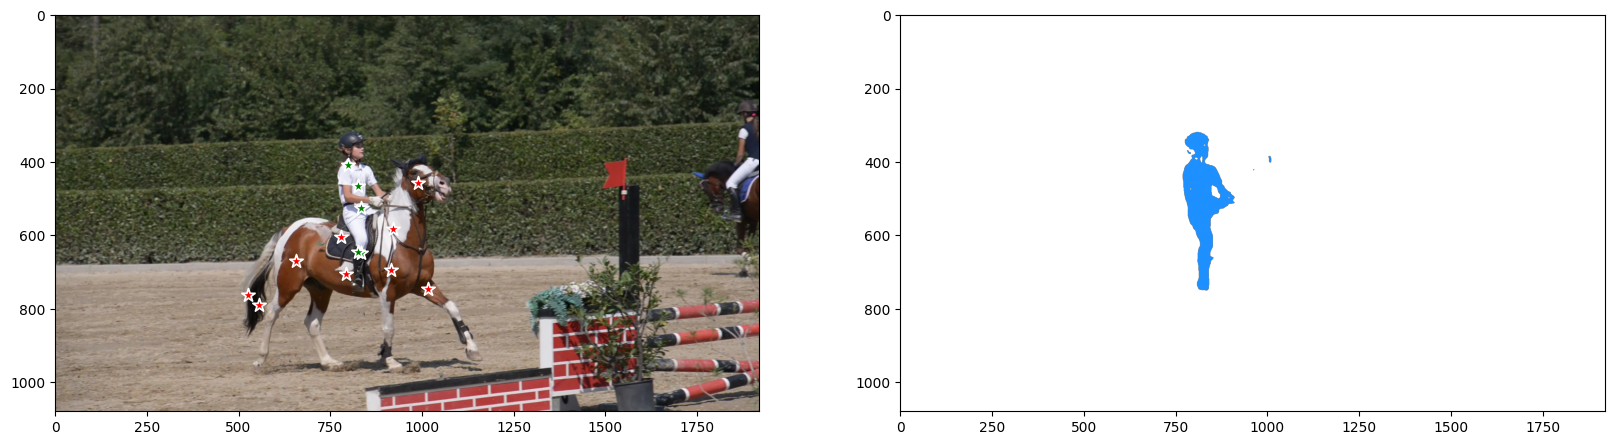

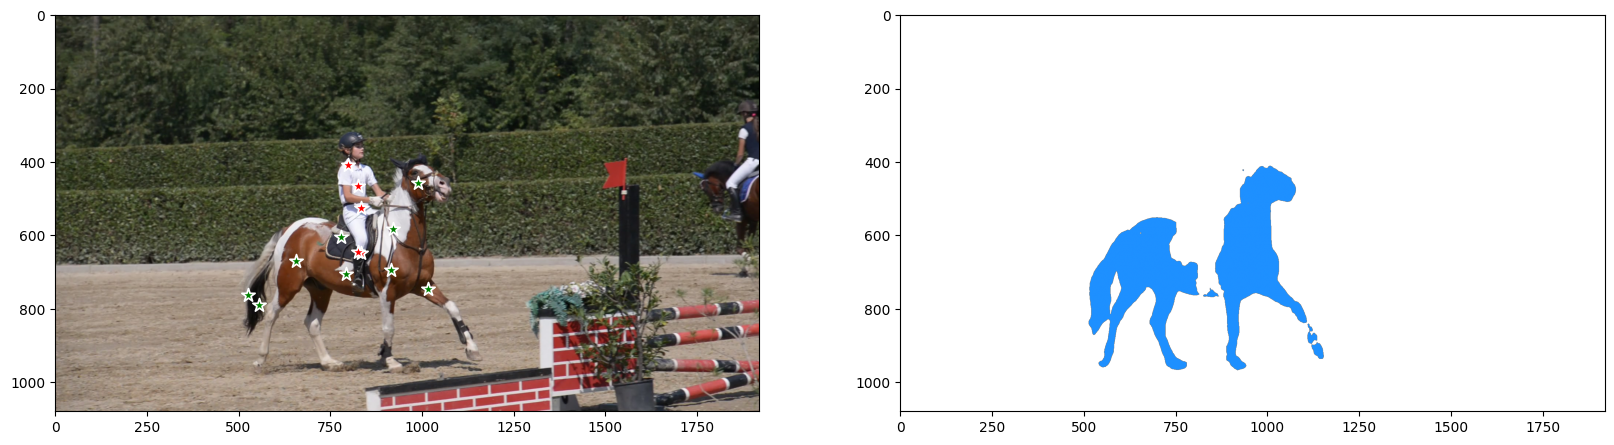

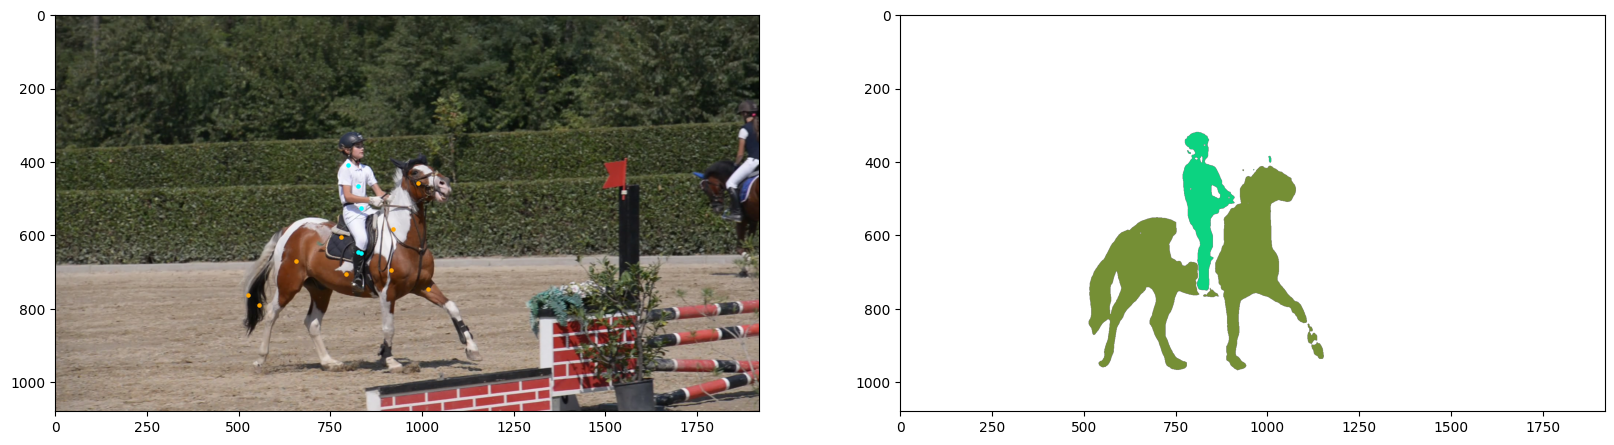

In [18]:
# For human: human is positive, horse is negative
masks, scores, logits = predictor.predict(
    point_coords=np.array(new_points_human + new_points_horse),
    point_labels=np.array([1]*len(new_points_human) + [0]*len(new_points_horse)),
    multimask_output=False,
)
    
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax1.imshow(new_img)
show_points(np.array(new_points_human + new_points_horse), np.array([1]*len(new_points_human) + [0]*len(new_points_horse)), ax1)
show_mask(masks[0], ax2, random_color=False)
plt.show()

# For horse: human is negative, horse is positive
masks, scores, logits = predictor.predict(
    point_coords=np.array(new_points_human + new_points_horse),
    point_labels=np.array([0]*len(new_points_human) + [1]*len(new_points_horse)),
    multimask_output=False,
)
    
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax1.imshow(new_img)
show_points(np.array(new_points_human + new_points_horse), np.array([0]*len(new_points_human) + [1]*len(new_points_horse)), ax1)
show_mask(masks[0], ax2, random_color=False)
plt.show()

# Together: batch of objects, not batch of images
input_point = np.array([new_points_human + new_points_horse]*2) 
input_label = np.array([[0]*len(new_points_human) + [1]*len(new_points_horse), 
                        [1]*len(new_points_human) + [0]*len(new_points_horse)])

transformed_points = predictor.transform.apply_coords_torch(torch.tensor(input_point).to(device), new_img.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=transformed_points,
    point_labels=torch.tensor(input_label).to(device),
    multimask_output=False,
)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax1.imshow(new_img)
ax1.scatter([p[0] for p in new_points_human], [p[1] for p in new_points_human], s=5, c='cyan')
ax1.scatter([p[0] for p in new_points_horse], [p[1] for p in new_points_horse], s=5, c='orange')
show_mask(masks[0].cpu().numpy(), ax2, random_color=True)
show_mask(masks[1].cpu().numpy(), ax2, random_color=True)
plt.show()